<a href="https://colab.research.google.com/github/Kashaf-Zia06/Python-AI-Bootcamp/blob/main/Student_Placement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,5)


## 1. Data Handling (NumPy & Pandas)

In [ ]:
# === 1.1 Load dataset into a Pandas DataFrame ===
# TODO: Update the file name/path to your Kaggle data
import zipfile
import pandas as pd

# === 1.1 Load dataset into a Pandas DataFrame ===
# Unzip the uploaded file
with zipfile.ZipFile("student.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Now read the CSV inside (replace 'student.csv' with the actual filename inside the zip)
DATA_PATH = "Placement.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())



Shape: (1000, 5)


,Student_ID,CGPA,Internships,Placed,Salary (INR LPA)
0,1,7.90,3,Yes,17.63
1,2,7.39,0,Yes,28.37
2,3,8.02,2,Yes,8.95
3,4,8.72,4,Yes,22.59
4,5,7.31,2,Yes,19.67


In [ ]:
# === 1.2 Initial checks ===
display(df.info())
display(df.describe(include='all').transpose())
print('\nNumber of duplicates:', df.duplicated().sum())
print('Total missing values:', df.isna().sum().sum())
display(df.isna().sum().sort_values(ascending=False).to_frame('missing_count'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Student_ID        1000 non-null   int64  
 1   CGPA              1000 non-null   float64
 2   Internships       1000 non-null   int64  
 3   Placed            1000 non-null   object 
 4   Salary (INR LPA)  1000 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Student_ID,1000.0,NaN,NaN,NaN,500.5,288.819436,1.0,250.75,500.5,750.25,1000.0
CGPA,1000.0,NaN,NaN,NaN,7.51556,0.783422,4.91,6.98,7.52,8.02,10.58
Internships,1000.0,NaN,NaN,NaN,2.045,1.424431,0.0,1.0,2.0,3.0,4.0
Placed,1000,2,Yes,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Salary (INR LPA),1000.0,NaN,NaN,NaN,11.79558,10.105559,0.0,0.0,11.715,20.935,29.9



Number of duplicates: 0
Total missing values: 0


,missing_count
Student_ID,0
CGPA,0
Internships,0
Placed,0
Salary (INR LPA),0


In [ ]:
# Handle missing values and duplicates ===

df = df.drop_duplicates().copy()

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

print('After cleaning → shape:', df.shape)
print('Remaining missing values:', df.isna().sum().sum())


After cleaning → shape: (1000, 5)
Remaining missing values: 0


In [ ]:
# Convert categorical → numerical (if needed)

TARGET_COL = 'Placed'

assert TARGET_COL in df.columns, f"TARGET_COL '{TARGET_COL}' not found in columns: {df.columns.tolist()}"

y_raw = df[TARGET_COL]
X_raw = df.drop(columns=[TARGET_COL])

# If the target is object/string, label-encode it for modeling
if y_raw.dtype == 'object' or str(y_raw.dtype).startswith('category'):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    target_classes_ = list(le.classes_)
else:
    y = y_raw.values
    target_classes_ = np.unique(y).tolist()

print('Target classes:', target_classes_)
print('Features shape:', X_raw.shape, '| Target shape:', y.shape)


Target classes: ['No', 'Yes']
Features shape: (1000, 4) | Target shape: (1000,)


## 2. Exploratory Data Analysis (EDA)

In [ ]:
# Basic statistics
stats_num = df[num_cols].describe().T
stats_num['skew'] = df[num_cols].skew()
stats_num['kurtosis'] = df[num_cols].kurtosis()
display(stats_num)

# Correlation (numeric only)
corr = df[num_cols].corr(numeric_only=True)
display(corr)


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Student_ID,1000.0,500.50000,288.819436,1.00,250.75,500.500,750.250,1000.00,0.000000,-1.200000
CGPA,1000.0,7.51556,0.783422,4.91,6.98,7.520,8.020,10.58,0.116510,0.072067
Internships,1000.0,2.04500,1.424431,0.00,1.00,2.000,3.000,4.00,-0.043981,-1.341958
Salary (INR LPA),1000.0,11.79558,10.105559,0.00,0.00,11.715,20.935,29.90,0.178659,-1.398617


,Student_ID,CGPA,Internships,Salary (INR LPA)
Student_ID,1.000000,0.035674,-0.013422,-0.000513
CGPA,0.035674,1.000000,-0.027987,-0.044499
Internships,-0.013422,-0.027987,1.000000,0.002298
Salary (INR LPA),-0.000513,-0.044499,0.002298,1.000000


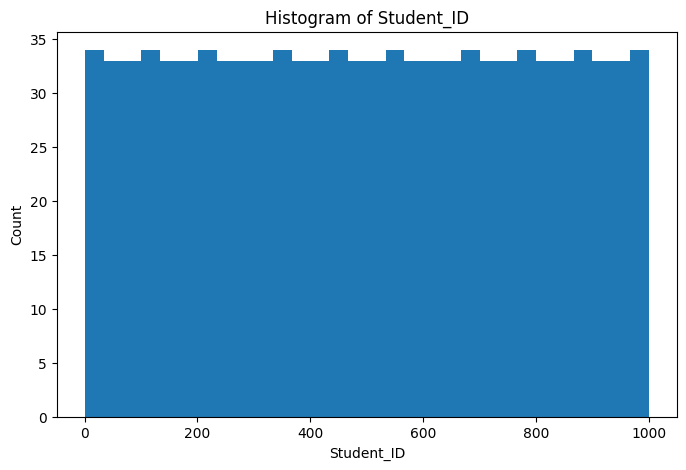

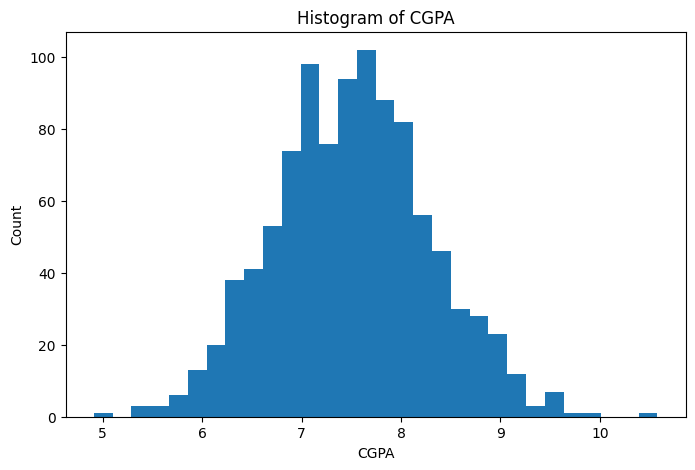

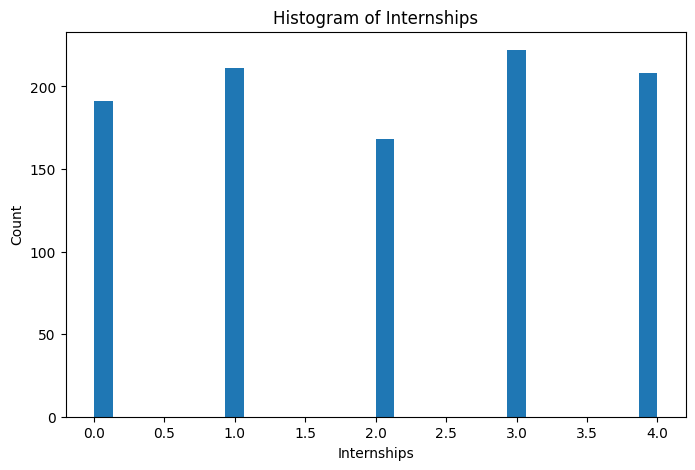

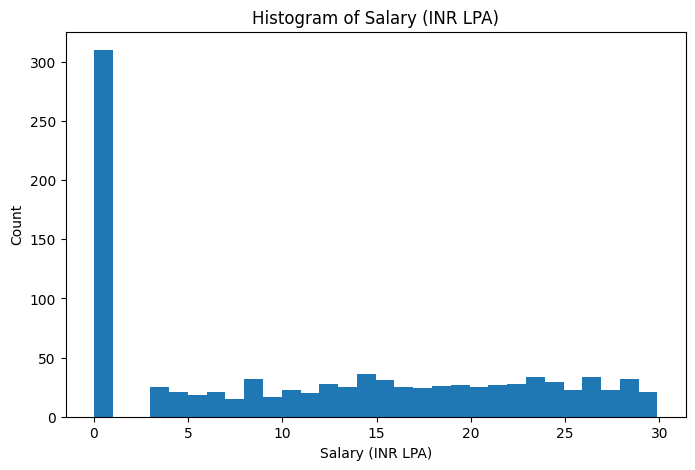

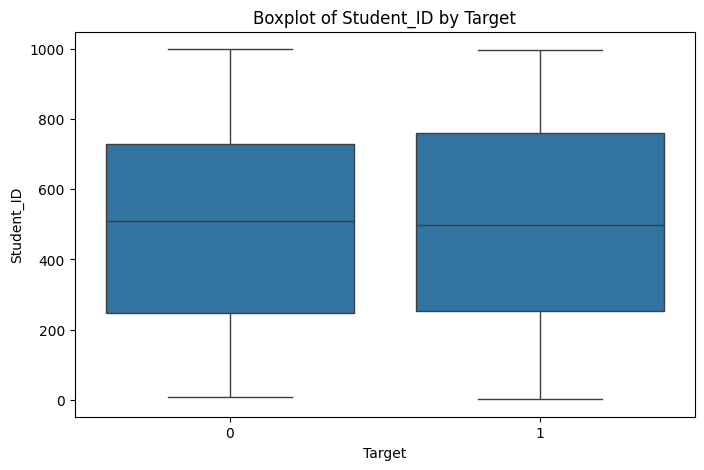

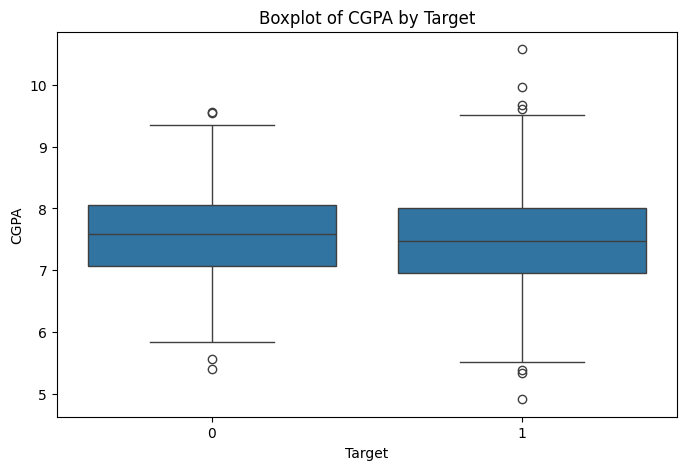

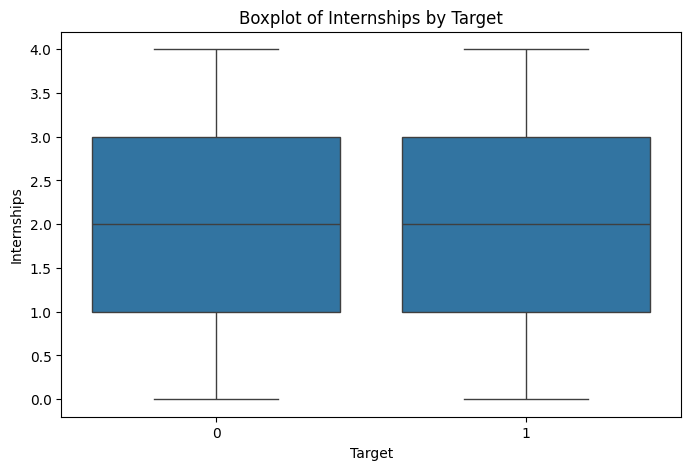

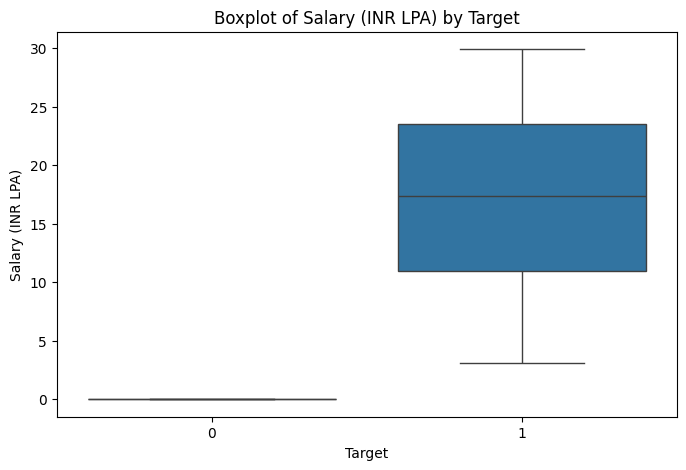

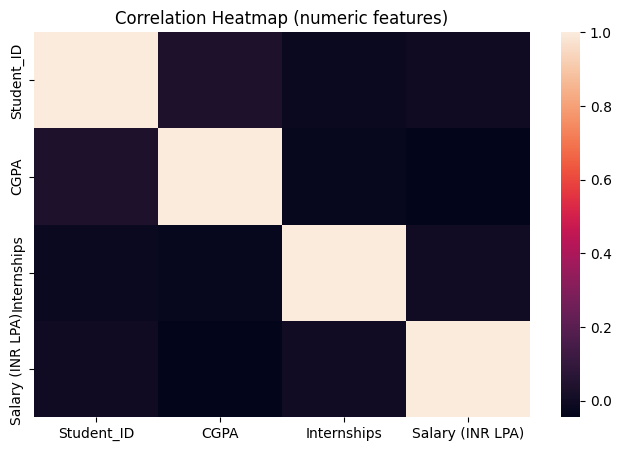

In [ ]:
# Visualizations
# Histograms for numeric columns
for c in num_cols[:10]:  # limit
    plt.figure()
    plt.hist(df[c].dropna(), bins=30)
    plt.title(f'Histogram of {c}')
    plt.xlabel(c); plt.ylabel('Count')
    plt.show()


if len(np.unique(y)) <= 10 and len(num_cols) > 0:
    for c in num_cols[:10]:
        plt.figure()
        sns.boxplot(x=y, y=df[c])
        plt.title(f'Boxplot of {c} by Target')
        plt.xlabel('Target'); plt.ylabel(c)
        plt.show()

# Heatmap of correlations (seaborn)
if len(num_cols) >= 2:
    plt.figure()
    sns.heatmap(corr, annot=False)
    plt.title('Correlation Heatmap (numeric features)')
    plt.show()


In [ ]:
#  Plotly

if len(num_cols) >= 2:
    x_col = num_cols[0]
    y_col = num_cols[1]
    fig = px.scatter(df, x=x_col, y=y_col, color=df[TARGET_COL].astype(str),
                     title=f'Interactive Scatter: {x_col} vs {y_col}')
    fig.show()
else:
    fig = px.histogram(df, x=TARGET_COL, title='Interactive Target Distribution')
    fig.show()


## 3. Feature Engineering

In [ ]:
# Split dataset into features and target
X = X_raw.copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numeric cols:', len(num_cols), '| Categorical cols:', len(cat_cols))


Numeric cols: 4 | Categorical cols: 0


In [ ]:
# Preprocessing & Scaling ===
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)


In [ ]:
# === 3.3 Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None
)
print('Train shape:', X_train.shape, '| Test shape:', X_test.shape)


Train shape: (800, 4) | Test shape: (200, 4)


## 4. Model Training

In [ ]:

def fit_and_report(clf, name: str):
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }
    return pipe, metrics

results = []
models = {
    'KNN (baseline)': KNeighborsClassifier(),
    'Decision Tree (baseline)': DecisionTreeClassifier(random_state=42),
    'Random Forest (baseline)': RandomForestClassifier(random_state=42)
}

fitted = {}
for name, clf in models.items():
    pipe, m = fit_and_report(clf, name)
    fitted[name] = pipe
    results.append(m)

baseline_df = pd.DataFrame(results).sort_values('f1_macro', ascending=False)
display(baseline_df)


,model,accuracy,precision_macro,recall_macro,f1_macro
1,Decision Tree (baseline),1.000,1.000000,1.000000,1.00000
2,Random Forest (baseline),1.000,1.000000,1.000000,1.00000
0,KNN (baseline),0.965,0.954131,0.965755,0.95962


## 5. Feature Importance (Random Forest)

,feature,importance
3,Salary (INR LPA),0.971272
0,Student_ID,0.014259
1,CGPA,0.012834
2,Internships,0.001636


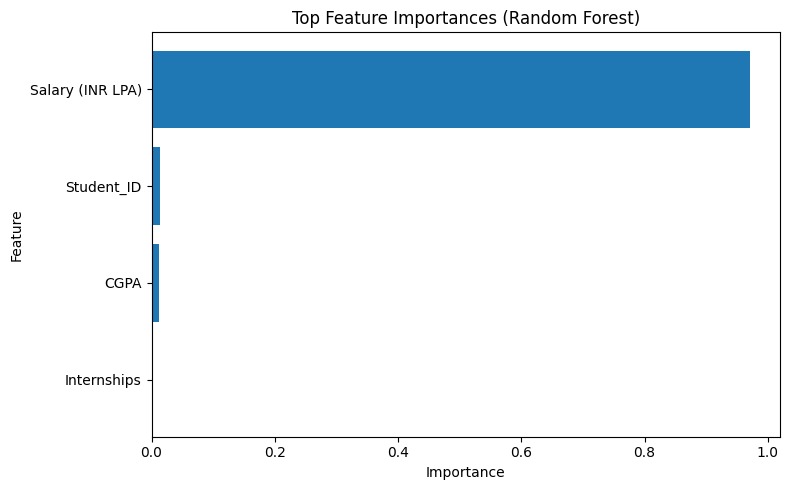

In [ ]:

rf = RandomForestClassifier(random_state=42)
rf_pipe = Pipeline(steps=[('preprocess', preprocess), ('model', rf)])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)


ohe = rf_pipe.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe']
cat_feature_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols)>0 else np.array([])
feature_names = np.concatenate([num_cols, cat_feature_names])


importances = rf_pipe.named_steps['model'].feature_importances_
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi = fi.sort_values('importance', ascending=False).head(25)
display(fi)


plt.figure()
plt.barh(fi['feature'][::-1], fi['importance'][::-1])
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## 6. Hyperparameter Tuning (RandomizedSearchCV)

In [ ]:
from scipy.stats import randint, uniform

def tune_model(name, estimator, param_dist, n_iter=25):
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', estimator)])
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions={f'model__{k}': v for k, v in param_dist.items()},
        n_iter=n_iter,
        scoring='f1_macro',
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    rs.fit(X_train, y_train)
    return rs

knn_params = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

dt_params = {
    'max_depth': randint(2, 50),
    'min_samples_split': randint(2, 50)
}

rf_params = {
    'n_estimators': randint(100, 800),
    'max_depth': randint(2, 50),
    'min_samples_split': randint(2, 50)
}

knn_rs = tune_model('KNN', KNeighborsClassifier(), knn_params)
dt_rs  = tune_model('DecisionTree', DecisionTreeClassifier(random_state=42), dt_params)
rf_rs  = tune_model('RandomForest', RandomForestClassifier(random_state=42), rf_params)

tuned_results = pd.DataFrame([
    {'model':'KNN (tuned)', 'best_score_cv_f1_macro': knn_rs.best_score_, 'best_params': knn_rs.best_params_},
    {'model':'Decision Tree (tuned)', 'best_score_cv_f1_macro': dt_rs.best_score_, 'best_params': dt_rs.best_params_},
    {'model':'Random Forest (tuned)', 'best_score_cv_f1_macro': rf_rs.best_score_, 'best_params': rf_rs.best_params_},
])
display(tuned_results)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


,model,best_score_cv_f1_macro,best_params
0,KNN (tuned),0.957709,"{'model__metric': 'manhattan', 'model__n_neigh..."
1,Decision Tree (tuned),1.000000,"{'model__max_depth': 40, 'model__min_samples_s..."
2,Random Forest (tuned),1.000000,"{'model__max_depth': 40, 'model__min_samples_s..."


## 7. Model Evaluation

Best tuned model by CV F1 (macro): Decision Tree
Accuracy: 1.0000 | Precision (macro): 1.0000 | Recall (macro): 1.0000 | F1 (macro): 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00       138

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



,No,Yes
No,62,0
Yes,0,138


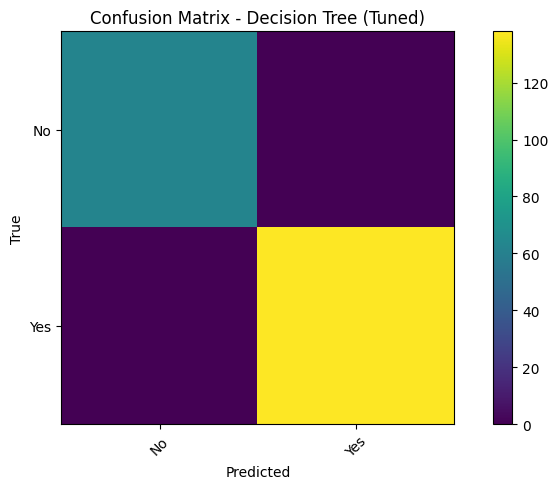

In [ ]:

best_rs = max([knn_rs, dt_rs, rf_rs], key=lambda rs: rs.best_score_)
best_name = 'KNN' if best_rs is knn_rs else ('Decision Tree' if best_rs is dt_rs else 'Random Forest')
print('Best tuned model by CV F1 (macro):', best_name)

best_model = best_rs.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1   = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Accuracy: {acc:.4f} | Precision (macro): {prec:.4f} | Recall (macro): {rec:.4f} | F1 (macro): {f1:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=target_classes_, columns=target_classes_ if len(target_classes_)==cm.shape[1] else range(cm.shape[1]))
display(cm_df)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title(f'Confusion Matrix - {best_name} (Tuned)')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, target_classes_[:len(tick_marks)], rotation=45)
plt.yticks(tick_marks, target_classes_[:len(tick_marks)])
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()


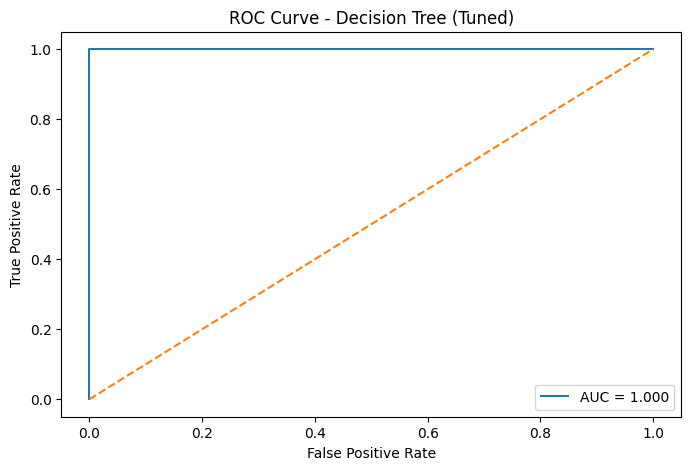

In [ ]:
# ROC Curve for the best model
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

classes = np.unique(y)
if len(classes) == 2:
    # Binary
    y_score = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--')
    plt.title(f'ROC Curve - {best_name} (Tuned)')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
else:
    # Multiclass OvR
    Y_test = label_binarize(y_test, classes=classes)
    if hasattr(best_model, 'predict_proba'):
        Y_score = best_model.predict_proba(X_test)
    else:
        # fallback
        Y_score = np.vstack([best_model.decision_function(X_test)]).T
    # Ensure shape [n_samples, n_classes]
    if Y_score.ndim == 1:
        Y_score = np.column_stack([1 - Y_score, Y_score])

    plt.figure()
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y_test[:, i], Y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {cls} (AUC={roc_auc:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.title(f'Multiclass ROC (OvR) - {best_name} (Tuned)')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
